In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Utilities 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter
0,1993-05-04,444.05,123.500000,-2.967463,-5.138645,-5.138644978283347,144.300,134.700,121.400,155.800
1,1993-05-05,444.52,123.610001,-3.741880,-5.885484,UNDERPERFORM,144.300,134.700,121.400,155.800
2,1993-05-06,443.26,123.309998,-3.958573,-6.192468,UNDERPERFORM,144.300,134.700,121.400,155.800
3,1993-05-07,442.31,122.980003,-3.868640,-5.762450,UNDERPERFORM,144.300,134.700,121.400,155.800
4,1993-05-10,442.80,122.699997,-3.514697,-5.811013,UNDERPERFORM,144.300,134.700,121.400,155.800
...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,342.829987,5.426902,-12.099380,UNDERPERFORM,280.126,233.199,272.154,341.963
7195,2021-11-26,4594.62,337.320007,4.573863,-12.112762,UNDERPERFORM,280.126,233.199,272.154,341.963
7196,2021-11-29,4655.27,342.600006,8.977288,-9.208957,UNDERPERFORM,280.126,233.199,272.154,341.963
7197,2021-11-30,4567.00,332.589996,6.305224,-11.221741,UNDERPERFORM,280.126,233.199,272.154,341.963


## Using data after 2000 

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,2000-01-13,1449.68,150.380005,-1.473467,-9.502313,UNDERPERFORM,170.000,149.400,134.500,190.900,3
81,2000,2,2000-02-10,1416.83,154.710007,-2.032872,-3.906828,UNDERPERFORM,171.000,149.800,133.600,191.600,3
82,2000,3,2000-03-09,1401.69,141.649994,-2.531813,-19.010864,UNDERPERFORM,170.900,150.000,133.700,191.900,3
83,2000,4,2000-04-13,1440.51,160.339996,-3.467247,-19.073340,UNDERPERFORM,171.200,150.300,133.800,192.400,3
84,2000,5,2000-05-11,1407.81,169.070007,-1.307432,-18.649855,UNDERPERFORM,172.200,151.500,136.600,193.100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-7.184331,-4.252775,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-6.940799,-3.697928,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-1.171440,1.016763,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,3.749053,-5.611348,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [4]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [5]:
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
data.head()

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,1449.68,150.380005,-1.473467,-9.502313,170.0,149.4,134.5,190.9,3
81,2000,2,1416.83,154.710007,-2.032872,-3.906828,171.0,149.8,133.6,191.6,3
82,2000,3,1401.69,141.649994,-2.531813,-19.010864,170.9,150.0,133.7,191.9,3
83,2000,4,1440.51,160.339996,-3.467247,-19.073340,171.2,150.3,133.8,192.4,3
84,2000,5,1407.81,169.070007,-1.307432,-18.649855,172.2,151.5,136.6,193.1,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [7]:
dd.data_summary(original)

,Info
Rows,263
Columns,6
Size in Memory,14.4 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.54,0.50,2,141
month,int64,0,0,1,6,12,6.48,3.44,12,22
overall,float64,0,0,170,221.19,280.13,220.053,28.073,254,3
utilities and public transportation,float64,0,0,149.40,206.12,233.20,197.24,22.76,249,3
fuels and utilities,float64,0,0,133.60,218.57,272.15,207.17,35.69,250,3
shelter,float64,0,0,190.90,249.64,341.96,257.93,40.16,256,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

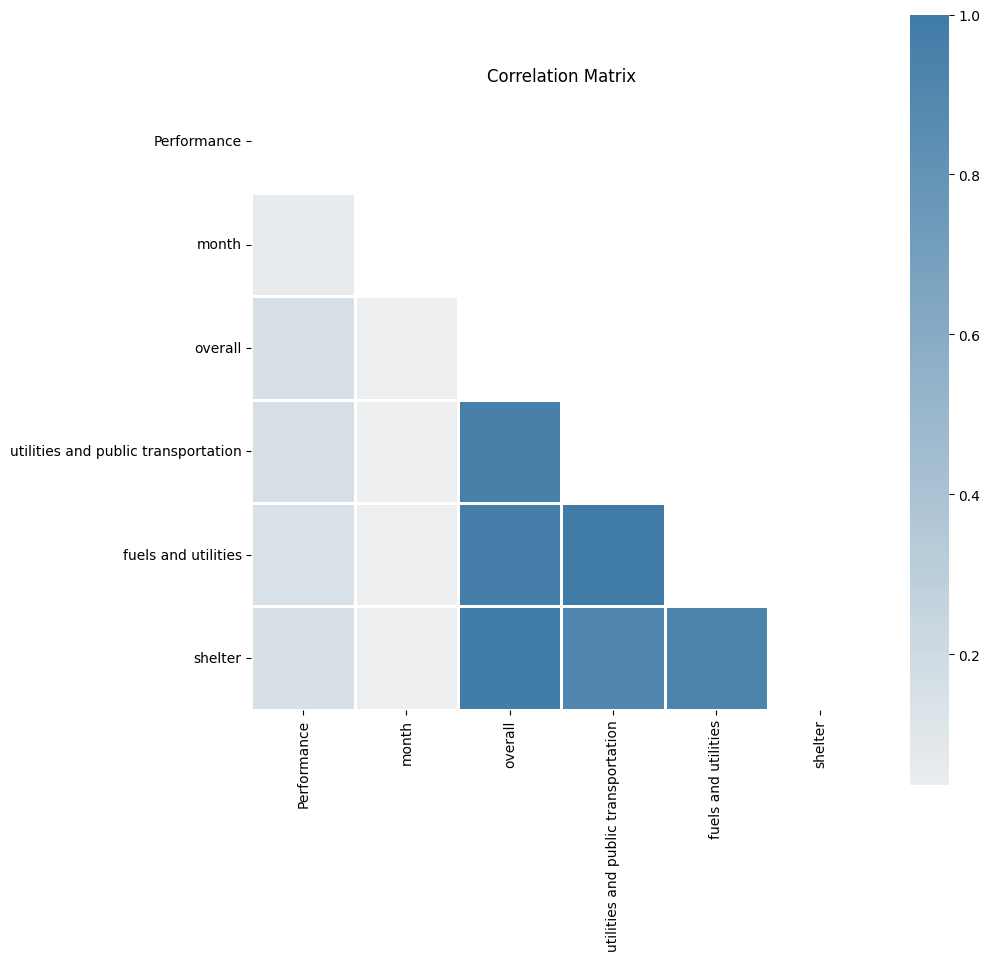

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2016,2,1987.297620,275.912356,-14.724794,-12.986002,260.087468,221.903382,260.867946,327.104982,3
1,2004,2,1123.710102,162.785777,-5.473493,-13.933979,197.351869,156.950340,143.035533,225.915350,3
2,2007,3,1237.761956,191.136586,-9.617636,-6.662344,224.547116,209.245734,225.612279,254.745030,3
3,2014,3,1195.960428,239.676623,-5.258265,4.155167,253.669345,225.105799,230.927433,345.944184,3
4,2014,2,1749.110182,274.873678,-6.520111,-9.605906,245.175488,216.675078,242.454052,319.331182,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2008,3,1201.878239,157.859384,-12.414447,-12.821135,224.217800,214.521149,220.446649,273.444749,3
9996,2015,2,2048.840718,194.735655,-0.642897,15.208611,251.727980,217.660982,243.545229,301.659733,3
9997,2009,2,1284.758204,225.374394,12.437684,9.290422,229.632129,214.623619,227.725193,263.482515,3
9998,2007,3,1297.527138,137.906892,-2.604303,-0.873167,239.672887,187.712746,202.850243,244.114913,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
samples.head()

,Performance,month,overall,utilities and public transportation,fuels and utilities,shelter
0,1,2,260.087468,221.903382,260.867946,327.104982
1,0,2,197.351869,156.950340,143.035533,225.915350
2,1,3,224.547116,209.245734,225.612279,254.745030
3,1,3,253.669345,225.105799,230.927433,345.944184
4,0,2,245.175488,216.675078,242.454052,319.331182


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,6
Size in Memory,468.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.42,0.49,2,5785
month,int64,0,0,1,3,12,3.12,1.91,12,4404
overall,float64,0,0,154.039,230.46,306.80,224.48,29.35,10000,1
utilities and public transportation,float64,0,0,145.93,207.65,249.75,197.84,24.35,10000,1
fuels and utilities,float64,0,0,127.090,220.49,288.021,210.56,37.89,10000,1
shelter,float64,0,0,155.68,257.48,364.54,264.078,46.76,9999,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

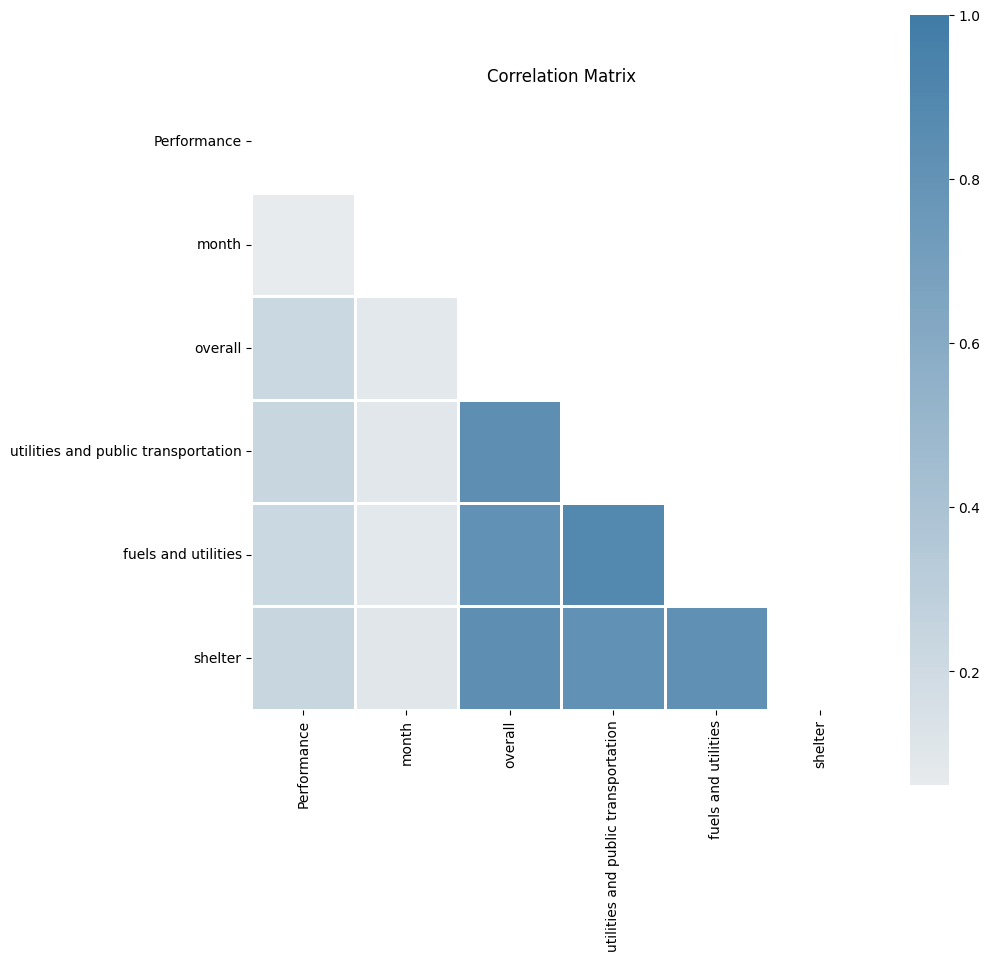

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 5785, 1: 4215})
Counter({1: 5785, 0: 5785})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  260.08746804,   221.90338237,   260.86794635, ...,
        57887.47964709, 72585.70196428, 85331.20497584],
       [  197.35186855,   156.95034028,   143.03553255, ...,
        22449.47550509, 35457.49109036, 32313.92242941],
       [  224.54711575,   209.24573419,   225.61227891, ...,
        47208.40694351, 53304.31073644, 57473.60665552],
       ...,
       [  198.72259862,   190.23520484,   137.7131636 , ...,
        26197.89188618, 44518.76642509, 32227.57937407],
       [  257.87313154,   214.13371583,   218.18526705, ...,
        46720.82197264, 71651.52878939, 73007.2229971 ],
       [  259.24117557,   218.47254982,   251.24789216, ...,
        54890.7676388 , 72720.92359541, 83630.54664899]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11570, 11)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(263, 11)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.630424,0.621206,0.662955,0.640653,0.638783,0.617188,0.674733,0.644679,0.513308,0.556522,0.453901,0.5
1,DecisionTreeClassifier,0.613137,0.60773,0.627356,0.616301,0.610439,0.593039,0.630605,0.611245,0.574144,0.612403,0.560284,0.585185
2,RandomForestClassifier,0.691876,0.683668,0.706709,0.692981,0.674732,0.656334,0.693238,0.674282,0.612167,0.663866,0.560284,0.607692
3,AdaBoostClassifier,0.624978,0.603835,0.726541,0.65942,0.63187,0.60468,0.698932,0.648399,0.623574,0.638158,0.687943,0.662116
4,GradientBoostingClassifier,0.635869,0.630113,0.65653,0.642884,0.628413,0.607004,0.666192,0.635222,0.589354,0.625954,0.58156,0.602941
5,ExtraTreesClassifier,0.708211,0.700379,0.718816,0.706727,0.689596,0.674227,0.698221,0.686014,0.577947,0.633929,0.503546,0.561265
6,BaggingClassifier,0.663094,0.676748,0.616983,0.643376,0.654338,0.657833,0.600712,0.627976,0.539924,0.602041,0.41844,0.493724
7,SVC,0.610285,0.591757,0.710971,0.645851,0.611476,0.579066,0.732384,0.646763,0.551331,0.585185,0.560284,0.572464
8,GaussianNB,0.603371,0.591259,0.669654,0.627923,0.608365,0.581829,0.688256,0.630584,0.589354,0.613793,0.631206,0.622378


## Using all data

In [22]:
data = pd.read_csv('../data/S&P 500 Utilities 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
0,1993,5,1993-05-13,439.23,120.120003,-4.763660,-7.500383,UNDERPERFORM,144.300,134.700,121.400,155.800,3
1,1993,6,1993-06-10,445.38,121.970001,-5.056491,-4.096555,OUTPERFORM,144.500,135.100,121.700,155.900,3
2,1993,7,1993-07-08,448.64,126.389999,-2.870751,4.696817,OUTPERFORM,144.800,135.700,122.100,156.200,3
3,1993,8,1993-08-12,448.96,129.559998,-3.840305,8.155937,OUTPERFORM,145.000,136.300,122.500,156.500,3
4,1993,9,1993-09-09,457.50,131.649994,-5.006125,10.528077,OUTPERFORM,145.600,136.300,122.600,156.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-7.184331,-4.252775,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-6.940799,-3.697928,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-1.171440,1.016763,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,3.749053,-5.611348,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [23]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,1995,8,1084.429246,111.417481,-2.590416,-3.134604,153.124502,155.755789,130.731610,153.944165,3
1,1999,7,239.949855,127.363641,-12.526220,18.257374,152.255554,132.484342,137.772848,192.765644,3
2,2001,10,490.623571,70.726276,-10.684577,-0.675159,160.903777,143.402678,135.287462,186.088748,3
3,2021,7,2819.722036,283.870513,2.553337,23.304631,241.552785,220.375348,253.033235,292.505880,3
4,2015,6,1646.994754,254.416346,3.615782,-6.926080,222.870316,203.536766,227.288940,227.523889,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2014,6,1357.979614,195.912604,-15.954118,-10.375802,220.682751,202.297272,215.062224,272.112640,3
9996,2018,6,2443.823463,213.024564,-10.779534,-9.917286,226.273536,210.936576,226.965496,298.925600,3
9997,2018,7,2376.699809,288.564507,-15.683600,-16.376339,245.234353,201.912900,242.996954,264.871452,3
9998,2002,6,1326.350944,185.954953,-4.830713,-6.667429,170.628361,150.552473,142.324541,194.263603,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.652176,0.666621,0.625915,0.643895,0.639496,0.639865,0.630493,0.635144,0.495627,0.586592,0.514706,0.548303
1,DecisionTreeClassifier,0.627075,0.640728,0.60239,0.618865,0.627237,0.628494,0.613848,0.621085,0.501458,0.57971,0.588235,0.583942
2,RandomForestClassifier,0.710659,0.735147,0.685398,0.705379,0.703777,0.700793,0.706391,0.703581,0.577259,0.633484,0.686275,0.658824
3,AdaBoostClassifier,0.643146,0.636372,0.675952,0.654678,0.641816,0.628275,0.686418,0.656061,0.571429,0.677019,0.534314,0.59726
4,GradientBoostingClassifier,0.652342,0.638915,0.709916,0.671754,0.648111,0.629108,0.713715,0.668746,0.507289,0.6,0.514706,0.55409
5,ExtraTreesClassifier,0.717783,0.745544,0.692356,0.713114,0.714049,0.710059,0.719041,0.714522,0.556851,0.616071,0.676471,0.64486
6,BaggingClassifier,0.671726,0.712255,0.594937,0.645883,0.662691,0.683056,0.601198,0.639518,0.539359,0.616162,0.598039,0.606965
7,SVC,0.626577,0.61949,0.65872,0.638216,0.622929,0.613043,0.657124,0.634319,0.516035,0.625,0.465686,0.533708
8,GaussianNB,0.575461,0.58948,0.498013,0.539832,0.569583,0.578743,0.496671,0.534575,0.510204,0.613924,0.47549,0.535912


## Using data after 2010 (Best Model)

In [25]:
data = pd.read_csv('../data/S&P 500 Utilities 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
200,2010,1,2010-01-14,1148.46,158.289993,8.787618,10.398931,OUTPERFORM,217.281,201.045,212.638,247.997,3
201,2010,2,2010-02-11,1078.47,146.449997,1.716544,-1.856322,UNDERPERFORM,217.353,202.330,214.506,247.914,3
202,2010,3,2010-03-11,1150.24,151.440002,2.657837,-3.288840,UNDERPERFORM,217.403,202.917,214.821,247.959,3
203,2010,4,2010-04-08,1186.44,152.529999,13.110628,-1.409093,UNDERPERFORM,217.290,203.124,214.303,248.128,3
204,2010,5,2010-05-13,1157.44,152.580002,-0.285160,-5.622562,UNDERPERFORM,217.199,203.501,213.427,248.295,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-7.184331,-4.252775,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-6.940799,-3.697928,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-1.171440,1.016763,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,3.749053,-5.611348,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [26]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2019,2,2594.315546,317.831755,-4.517905,-2.136129,251.875680,215.891140,240.916688,324.786060,3
1,2015,3,2005.296950,207.797277,3.866694,4.229582,245.564285,205.295289,226.572144,258.929196,3
2,2009,4,1482.983180,191.831467,-7.295150,1.612085,257.146522,211.926757,224.498332,266.033722,3
3,2016,3,2272.343413,236.011001,-7.565325,-0.569806,242.677045,218.724628,244.998911,285.141968,3
4,2011,3,1288.516826,182.404030,-8.488931,-1.965939,220.687943,207.060889,224.858809,248.260198,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2015,2,2017.345924,210.743035,-0.369832,-1.796355,243.763577,217.027391,221.407133,282.059967,3
9996,2008,2,560.775062,162.685959,-13.709738,3.006442,222.664570,205.699877,217.949165,235.786035,3
9997,2020,2,2276.060116,239.047730,-7.507695,-2.884208,253.208644,216.091380,238.923986,289.480126,3
9998,2011,3,1158.480910,186.487398,-2.943620,-1.309194,227.412220,206.962262,223.266246,253.806619,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.660604,0.688076,0.604524,0.641874,0.642662,0.667335,0.595707,0.62949,0.503497,0.576471,0.583333,0.579882
1,DecisionTreeClassifier,0.654597,0.669511,0.623363,0.6442,0.639319,0.655063,0.617174,0.635554,0.559441,0.608247,0.702381,0.651934
2,RandomForestClassifier,0.726393,0.764225,0.680489,0.715984,0.711638,0.739159,0.670841,0.703345,0.622378,0.638889,0.821429,0.71875
3,AdaBoostClassifier,0.626263,0.63595,0.602096,0.617682,0.623215,0.636307,0.608229,0.621951,0.615385,0.655914,0.72619,0.689266
4,GradientBoostingClassifier,0.63857,0.649381,0.613492,0.629976,0.625342,0.6367,0.616577,0.626477,0.615385,0.646465,0.761905,0.699454
5,ExtraTreesClassifier,0.758222,0.794373,0.722572,0.752381,0.735339,0.753778,0.713775,0.733231,0.622378,0.636364,0.833333,0.721649
6,BaggingClassifier,0.678759,0.732486,0.585378,0.64749,0.66302,0.710682,0.571258,0.633388,0.545455,0.606742,0.642857,0.624277
7,SVC,0.626112,0.630867,0.620783,0.624855,0.622607,0.632058,0.620751,0.626354,0.608392,0.645833,0.738095,0.688889
8,GaussianNB,0.551733,0.570933,0.418868,0.482992,0.549377,0.576741,0.434705,0.49575,0.566434,0.625,0.654762,0.639535


### Voting Classifier

In [28]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.717107,0.740645,0.684556,0.711497
